In [1]:
# Importing libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from graphs import readTableDate
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

69/69 - 1s - loss: 0.0301


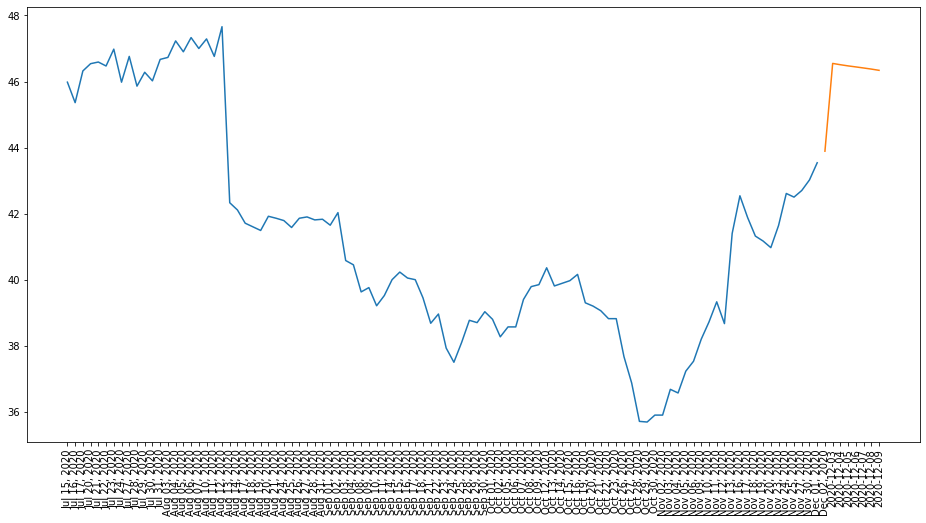

In [116]:
# Create Dataframe
def dataFunc(stock):
    df = readTableDate(stock)
    data = df.sort_index(ascending=False, axis=0)
    return data

def newDataFunc(stock):
    df = dataFunc(stock)
    newData = pd.DataFrame(index=range(0, len(df)), columns=["Date", "Close"])

    for i in range(0, len(df)):
        newData["Date"][len(df)-i-1] = df["Date"][i]
        newData["Close"][len(df)-i-1] = df["Close"][i]
    
    # Setting Index
    newData.index = newData.Date
    newData.drop("Date", axis=1, inplace=True)
    
    return newData

def lstmTestModel(stock):
    # Creating train and test sets
    newData = newDataFunc(stock)
    dataset = newData.values

    splitPercent = 0.8
    split = int(splitPercent * len(newData))

    train = dataset[:split]
    valid = dataset[split:]

    # Convert dataset into x_train and y_train
    lookBack= 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaledData = scaler.fit_transform(dataset)

    xTrain, yTrain = [], []
    for i in range(lookBack, len(train)):
        xTrain.append(scaledData[i-lookBack:i,0])
        yTrain.append(scaledData[i,0])
    xTrain, yTrain = np.array(xTrain), np.array(yTrain)

    xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))

    # Create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(xTrain.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(xTrain, yTrain, epochs=1, batch_size=1, verbose=2)    
    
    # predict value training
    inputs = newData[len(newData) - len(valid) - lookBack:].values
    inputs = inputs.reshape(-1,1)
    inputs = scaler.transform(inputs)
    xTest = []
    for i in range(lookBack, inputs.shape[0]):
        xTest.append(inputs[i-lookBack:i, 0])
    xTest=np.array(xTest)

    xTest=np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))
    closingPrice = model.predict(xTest)
    closingPrice = scaler.inverse_transform(closingPrice)
    
    # Result
    rms = np.sqrt(np.mean(np.power((valid-closingPrice), 2)))
      
    # Plotting
    train = newData[:split]
    valid = newData[split:]
    valid['Predictions'] = closingPrice
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.show()
    return rms



c:\users\ralph\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


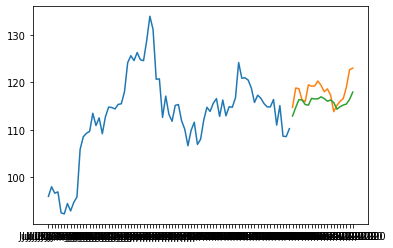

In [70]:
# Plotting
train = newData[:split]
valid = newData[split:]
valid['Predictions'] = closingPrice
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])